# Implementation

In this implementaiton we'll keep things very simple with an Oracle that just AND's everything
(so we already know, in advance, that the answer has to be $\ket{111}$)

In [1]:
# visualize stuff
import matplotlib.pyplot as plt

# import Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer, execute

from qiskit.visualization import plot_histogram

In [2]:
n = 3

# register naming code obtained from: 
# https://quantumcomputing.stackexchange.com/questions/2177/how-can-i-implement-an-n-bit-toffoli-gate
# credits to Ali Javadi for their answer

# label our qubits
function_inputs = QuantumRegister(n, "x")
target = QuantumRegister(1, "f(x)")
# store our results here
classical_registers = ClassicalRegister(3)

circuit = QuantumCircuit(function_inputs, target, classical_registers)

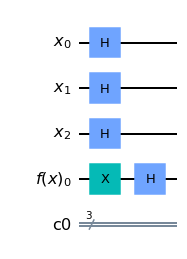

In [3]:
# Initialization phase

# apply Hadamards to three qubits
circuit.h(0)
circuit.h(1)
circuit.h(2)

# Get the last hadamard in the kickback position
circuit.x(3)
circuit.h(3)

circuit.draw(output="mpl")

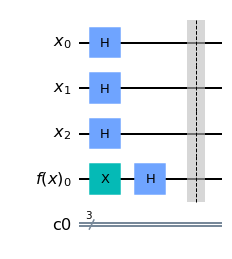

In [4]:
# barrier, used to visually seperate parts of the circuit but also
# lets Qiskit know that if any optimizations/gate reductions are done that they are limited
# to the barrier part of the circuit (you can't look outside the barrier for other gates)
# see: 
# https://quantumcomputing.stackexchange.com/questions/8369/what-is-a-barrier-in-qiskit-circuits
circuit.barrier()
circuit.draw(output="mpl")

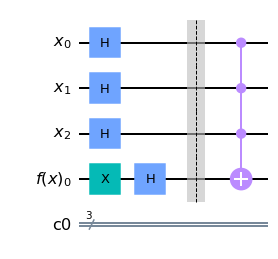

In [5]:
# Create an Oracle
# In this case, we want to solve for (x0 AND x1 AND x2)

# Note that when the circuit actually gets run on hardware, the gate actually gets 
# broken down into smaller gates (so this one may get broken down in CCX gates, and even further 
# to CX and other single qubit gates) that are native to the hardware (the hardware 
# may only support
# a certain subset of gates, although that subset is capable of generating any other 
# gate's operations

# Inspiration for Oracle from: https://cnot.io/quantum_algorithms/grover/grovers_algorithm.html
# as well as Ryan LaRose's QuIC Seminar notes on Grover's Algorithm: 
# https://www.ryanlarose.com/uploads/1/1/5/8/115879647/grover.pdf

circuit.mcx([0,1,2],3)
circuit.draw(output="mpl")

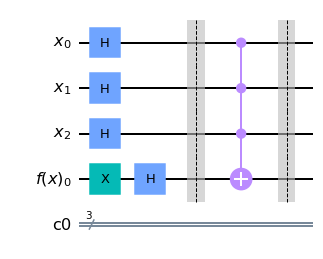

In [6]:
# oracle complete, put the barrier down
circuit.barrier()
circuit.draw(output="mpl")

Now we have to implement Grover's operator. To do so we can take a look at the formulation of the operator:
$$
2\ket{\psi}\bra{\psi} - I
$$

This by itself isn't very helpful for mapping the problem on to the computer but it's secondary formulation is
$$
H^{\otimes n} \left( 2\ket{0^{\otimes n}}\bra{0^{\otimes n}}  - I \right) H^{\otimes n} 
$$

We know we need to apply Hadamards before and after but how about $\left( 2\ket{0^{\otimes n}}\bra{0^{\otimes n}}  - I \right)$. How is that implemented?

Let's remind ourselves of what it does. Given a superposition of states, if the state is the all-0 state, so something like $\ket{000}$, then nothing should happen. However, if we have any other state the phase should be flipped.

It turns out you can use a CCZ (Controlled-Controlled-Z) gate and a couple extra gates to achieve this behavior (with an ignorable global phase) (source for statement and the circuit implementation of the operator used below: [Quantum Computing - Beginner's 4 week course - Week3, 3-qubit Grover's Algorithm](https://you.stonybrook.edu/qcomputing/2018/07/18/2-3-qubit-grovers-algorithm/) by Eric Li as well as Martin Vesely's answer to [Grover diffusion operator for a 3 qubit system](https://quantumcomputing.stackexchange.com/questions/9531/grover-diffusion-operator-for-a-3-qubit-system)

Recall that the $Z$ gate has the following behavior:
    
$$Z\ket{0} = \ket{0}$$
$$Z\ket{1} = -\ket{1}$$

If we make it a controlled controlled gate, two of the input qubits must both be $\ket{1}$ before the Z gate gets applied. Furthermore, if we are in the $\ket{111}$ state then it becomes $-\ket{111}$

Now I make the claim that if we put X gate's in front of and behind the CCZ that we get the desired behavior that all states except $\ket{000}$ get flipped. 

Quite the claim, eh? Let's see some proof:

We'll start with the equal superposition state:

$$
\frac{1}{2\sqrt{2}}\ket{000} + \cdots + \frac{1}{2\sqrt{2}}\ket{111}
$$

Don't worry about the probability amplitude values for now, we just care about the signs.

When I apply the X gate to all of the qubits, we essentially invert all the values, so now our states look like they're in reverse order:

$$
\frac{1}{2\sqrt{2}}\ket{111} + \cdots + \frac{1}{2\sqrt{2}}\ket{000}
$$

If we apply the CCZ gate only $\ket{111}$ sees its sign change

$$
-\frac{1}{2\sqrt{2}}\ket{111} + \cdots + \frac{1}{2\sqrt{2}}\ket{000}
$$

Now we apply the X gates again and get the following:

$$
-\frac{1}{2\sqrt{2}}\ket{000} + \cdots + \frac{1}{2\sqrt{2}}\ket{111}
$$

But wait a minute, haven't we done the exact opposite of what we wanted to do? 
Not quite. Remember our (ignorable) friend global phase?

$$
-\left(\frac{1}{2\sqrt{2}}\ket{000} - \cdots - \frac{1}{2\sqrt{2}}\ket{111}\right)
$$

So we HAVE accomplished what we wanted! 

BUT, there's another catch. There isn't really such a thing as a native CCZ gate, so we need to
use existing gates that will perform the same thing as a CCZ. There is an identity that
can be shown where if we take any CX gate and wrap the target qubit with Hadamards you get the same behavior as a CZ gate: https://qiskit.org/textbook/ch-gates/more-circuit-identities.html


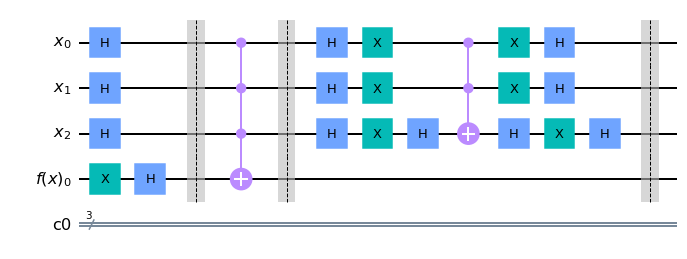

In [7]:
for i in range(3):
    circuit.h(i)

# 2|0><0| - I
for i in range(3):
    circuit.x(i)
circuit.h(2)
circuit.mcx([0,1],2)
circuit.h(2)
for i in range(3):
    circuit.x(i)

for i in range(3):
    circuit.h(i)
circuit.barrier()
circuit.draw(output="mpl")

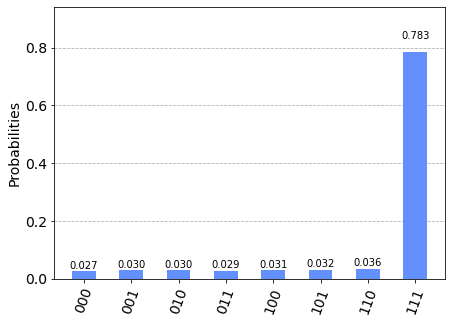

In [8]:
# get results
circuit.measure([0,1,2], [0,1,2])

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend)
plot_histogram(job.result().get_counts())

Awesome, we've implemented one iteration of the Grover algorithm. However, to apply another iteration we have to invoke the Oracle and Grover's operator again.

Recall from the presentation that it is optimal to apply it $\frac{\pi}{4}\sqrt{N}$ times (where $N$ are the total number of solutions for an Oracle with a single solution, and $\frac{\pi}{4}\sqrt{\frac{N}{k}}$ if there are $k$ solutions. 

Sources for the above information on how many times to apply the operation: 
* ["Lecture 22, Tues April 11: Grover" by Scott Aaronson](https://www.scottaaronson.com/qclec/22.pdf)
* ["Tutorial: Implement Grover's search algorithm in Q#", section on Number of Iterations](https://docs.microsoft.com/en-us/azure/quantum/tutorial-qdk-grovers-search?tabs=tabid-visualstudio#number-of-iterations)